# 회귀 - 주택 예측

Kaggle의 "House Prices: Advanced Regression Techniques" 대회 데이터를 기반으로 주택 가격을 예측하는 회귀 분석을 수행한다.  

학습 데이터에는 Ames 도시의 다양한 주택 특성과 실제 판매 가격이 포함되어 있으며,  
예측 성능 평가는 RMSE (Root Mean Squared Error) 지표를 기준으로 수행된다.

<br>

## 목차 및 실험 방향

1. 데이터 로드 및 확인
    
    1.1 &nbsp;라이브러리 및 데이터 불러오기  
    1.2 &nbsp;데이터 확인  
    1.3 &nbsp;결측치 및 이상치 확인  
    
2. 데이터 전처리 로그 변환
    
    2.1 &nbsp;로그 변환  
    2.2 &nbsp;결측치 처리  
    2.3 &nbsp;One-Hot Encoding  
    2.4 &nbsp;이상치 처리  
    2.5 &nbsp;Train/Test 데이터 분리  

3. 모델 학습 및 평가 함수 정의
    
    3.1 &nbsp;회귀 모델 성능 평가 함수  
    3.2 &nbsp;회귀 모델 학습 및 평가 함수  
    3.3 &nbsp;개별 모델 실행 함수  
    3.4 &nbsp;회귀 계수 비교  

4. 모델 비교 및 선택
    
    4.1 &nbsp;LinearRegression  
    4.2 &nbsp;Ridge  
    4.3 &nbsp;Lasso  
    4.4 &nbsp;RandomForest  
    4.5 &nbsp;XGBoost  
    4.6 &nbsp;LightGBM  
    4.7 &nbsp;Baseline 모델 성능 비교  
    
5. 하이퍼파라미터 튜닝
    
    5.1 &nbsp;GridSearch: LightGBM  
    5.2 &nbsp;GridSearch: XGBoost  
    5.3 &nbsp;RandomSearch: LightGBM  
    5.4 &nbsp;RandomSearch: XGBoost  

6. Fine-tuning

    6.1 &nbsp;LightGBM  
    6.2 &nbsp;XGBoost  

7. Stacking
    
8. Submission

<br>
<br>

Baseline 성능 비교 결과를 기반으로   
다음의 단계로 실험을 진행하여 최종 모델을 선정한다.

<br>

| **Model** | **RMSLE** | **RMSE** | **MSE** |
| --- | --- | --- | --- |
| **3** | Lasso | 0.111 | 20699.763 |
| **2** | Ridge | 0.119 | 20464.637 |
| **1** | Ridge | 0.120 | 20872.356 |
| **0** | LinearRegression | 0.121 | 21279.837 |
| **9** | LightGBM | 0.127 | 23768.878 |
| **10** | LightGBM | 0.127 | 23768.878 |
| **6** | RandomForest | 0.129 | 23775.423 |
| **5** | RandomForest | 0.130 | 23937.851 |
| **7** | XGBoost | 0.135 | 24707.331 |
| **8** | XGBoost | 0.135 | 24707.331 |
| **4** | Lasso | 0.176 | 34579.264 |

<br>

>(1) 트리 기반 모델 하이퍼파라미터 튜닝  
> ⸰ &nbsp;&nbsp;LightGBM과 XGBoost의 주요 하이퍼파라미터를 대상으로 GridSearchCV와 RandomizedSearchCV 적용   
>  ⸰ &nbsp;&nbsp;목표: 선형 회귀 기반 모델보다 우수한 성능 확보

>(2) 스태킹(Ensemble Stacking) 적용  
⸰ &nbsp;&nbsp;선형 모델(Ridge, Lasso, - LinearRegression)과 트리 기반 모델(LightGBM, XGBoost, RandomForest)을 Base Learner로 사용  
⸰ &nbsp;&nbsp;메타 모델은 기본적으로 Lasso 또는 XGBoost 등으로 설정하여 조합 실험 예정  
⸰ &nbsp;&nbsp;목표: 예측 결과를 개별 모델 대비 더 낮은 RMSE로 최종 향상시키는 것

>(3) 캐글 제출  
⸰ &nbsp;&nbsp;최종 예측값은 로그 변환 역변환 후 submission.csv 파일로 저장  
⸰ &nbsp;&nbsp;Kaggle 평가 기준은 RMSE이므로 튜닝과 스태킹 시 해당 기준 고려

<br>

## 1. 데이터 로드 및 확인


### 1.1 &nbsp;라이브러리 및 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_org = pd.read_csv('/content/drive/MyDrive/DS/ML/train_house1.csv')
test_org = pd.read_csv('/content/drive/MyDrive/DS/ML/test_house1.csv')

train_df = train_org.copy()
test_df = test_org.copy()

<br>

### 1.2 &nbsp;데이터 확인

해당 데이터 셋은 미국 아이오와 주 에임스(Ames) 지방의 주택 가격 정보를 담고 있으며, 총 81개의 피처로 구성되어 있다.


In [4]:
print(train_df.shape)
train_df.head(3)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
print(test_df.shape)
test_df.head(3)

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [6]:
# 전체 데이터에서 학습 데이터의 비율 확인
print(len(train_df), len(test_df))
len(train_df)/(len(train_df) + len(test_df))

1460 1459


0.5001712915381981

<br>

### 1.3 &nbsp;결측치 및 이상치 확인

In [7]:
# 결측치 확인
train_df.isnull().sum().sum()

np.int64(7829)

In [8]:
# 중복값 확인
train_df[train_df.duplicated() == 1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [9]:
print('데이터 세트 Shape:', train_df.shape)
print('\n전체 feature type \n',train_df.dtypes.value_counts())
isnull_series = train_df.isnull().sum()
print('\nNull 컬럼과 건수:')
print(isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트 Shape: (1460, 81)

전체 feature type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 건수:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


- 데이터셋은 1460개의 레코드와 81개의 피처로 구성되어 있으며, Target을 제외한 80개의 피처 중 43개가 문자형이며 나무지가 숫자형이다.

- PoolQC, MiscFeature, Alley,Fence는 1000개가 넘는 데이터가 Null이다. 데이터 양에 비해 결측치가 많은 피처는 제거하겠다.

회귀 모델을 적용하기 전, target값의 분포도가 정규 분포인지 확인한다.

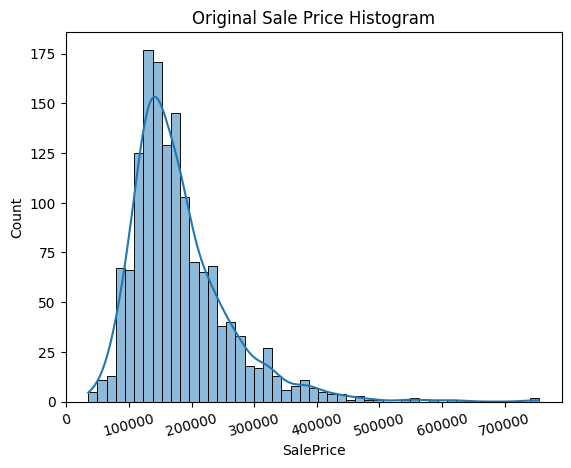

In [10]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(train_df['SalePrice'], kde=True)
plt.show()

데이터 값의 분포가 중심에서 왼쪽으로 치우진 형태로, 정규분포에서 벗어나 있다.

이를 정규분포 형태로 변환하기 위해 전처리 시 로그 변환을 적용하겠다.

<br>

## 2. 데이터 전처리

In [11]:
train_org = pd.read_csv('/content/drive/MyDrive/DS/ML/train_house1.csv')
test_org = pd.read_csv('/content/drive/MyDrive/DS/ML/test_house1.csv')

train_df = train_org.copy()
test_df = test_org.copy()

### 2.1 &nbsp;로그 변환

- 타겟 피처 SalePrice는 주택의 최종 판매 가격치로, 대부분의 값이 낮은 수치에 몰려 있고 일부 값만 매우 큰 우측 편향(Right Skewed) 분포를 보인다.

- 극단적인 이상치(outlier)가 많고 정규성이 떨어지므로 모델이 이를 기준으로 학습하게 되면 예측이 왜곡될 수 있다.


데이터를 정규분포에 가깝게 만들고, 이상치를 로그 변환으로 눌러 모델 안정성과 예측 정확도를 높이기 위해 로그 변환을 수행한다. 특히 MSE 기반 회귀에서는 큰 오차에 민감하므로 로그로 줄여주면 모델이 작은 수치도 잘 학습할 수 있게 된다.

In [12]:
# # 로그 변환
# y_target_log = np.log1p(y_target)

In [13]:
# 로그 변환
original_SalePrice = train_df['SalePrice']
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

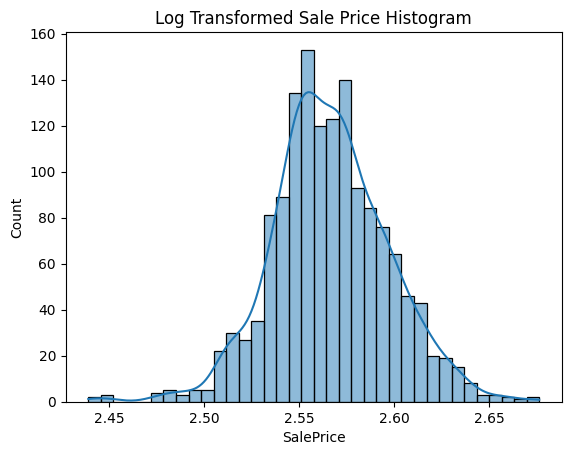

In [14]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(train_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

<br>

로그 변환 후 로그 스케일에서 타깃값의 분포를 확인해 본다.

In [15]:
y_target = train_df['SalePrice']  # 타겟 지정

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y_target, test_size=0.3, random_state=156)

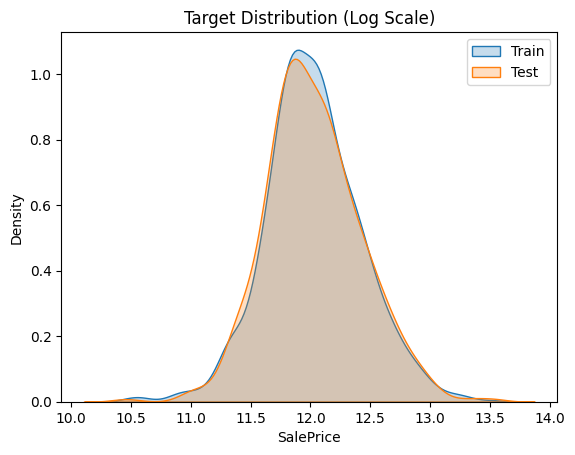

In [17]:
sns.kdeplot(y_train, label='Train', fill=True)
sns.kdeplot(y_test, label='Test', fill=True)
plt.legend()
plt.title('Target Distribution (Log Scale)')
plt.show()

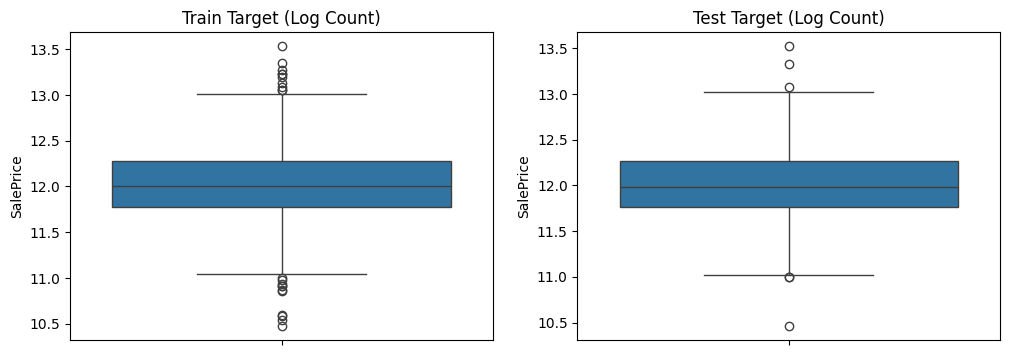

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y_train)
plt.title('Train Target (Log Count)')

plt.subplot(1, 2, 2)
sns.boxplot(y_test)
plt.title('Test Target (Log Count)')
plt.show()

<br>

### 2.2 &nbsp;결측치 처리

In [19]:
# 결측치가 많은 컬럼 및 불필요한 컬럼 제거
drop_columns = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence','FireplaceQu']
train_df.drop(drop_columns, axis=1 , inplace=True)

In [20]:
# Drop 하지 않는 숫자형 Null 컬럼들은 평균값으로 대체
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())  # mean

In [21]:
# num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
# train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

In [22]:
# Null 값이 있는 피처명과 타입 추출
null_column_count = train_df.isnull().sum()[train_df.isnull().sum() > 0]
print('## Null 피처 type')
print(train_df.dtypes[null_column_count.index])

## Null 피처 type
MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


이제 문자형 피처에만 Null 값이 존재한다. 문자형 피처는 모두 원-핫 인코딩으로 변환하겠다.

In [23]:
train_df.shape

(1460, 75)

In [24]:
isnull_series = train_df.isnull().sum()
print('\nNull 컬럼과 그 건수')
print(isnull_series[isnull_series > 0].sort_values(ascending=False))


Null 컬럼과 그 건수
MasVnrType      872
GarageQual       81
GarageCond       81
GarageFinish     81
GarageType       81
BsmtFinType2     38
BsmtExposure     38
BsmtCond         37
BsmtQual         37
BsmtFinType1     37
Electrical        1
dtype: int64


<br>

### 2.3 &nbsp;One-Hot Encoding

One-Hot Encoding을 통해 Train/Test 간 타겟 분포가 더 정규 분포에 가까워지고, 이상치 영향도 감소하여
전체적으로 모델 학습에 적합한 분포 형성을 기대한다.

In [25]:
print('get_dummies() 수행 전 데이터 Shape:', train_df.shape)
train_df_ohe = pd.get_dummies(train_df)
print('get_dummies() 수행 후 데이터 Shape:', train_df_ohe.shape)

null_column_count = train_df_ohe.isnull().sum()[train_df_ohe.isnull().sum() > 0]
print('\n## Null 피처의 Type ')
print(train_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 270)

## Null 피처의 Type 
Series([], dtype: object)


In [26]:
train_df_ohe

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,False,True,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,False,True,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,False,True,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,False,True,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,False,False,False,True,False,False,False,False,True,False
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,False,False,False,True,False,False,False,False,True,False
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,False,False,False,True,False,False,False,False,True,False


<br>

### 2.4 &nbsp;이상치 처리

수치형 피처의 왜도(Skewness)를 계산하고 왜도가 큰 피처(>1)를 선별한다.

- 로그 변환 등 편향 조정을 위한 후보 피처 탐색 목적

In [27]:
from scipy.stats import skew

# 수치형 컬럼 인덱스만 추출 (object와 bool 타입 제외)
features_index = train_df_ohe.dtypes[(train_df_ohe.dtypes != 'object') & (train_df_ohe.dtypes != 'bool')].index

# 각 수치형 피처의 왜도(Skewness) 계산 (결측값 제외)
numeric_df = train_df_ohe[features_index].astype(float)

# 왜도 계산
skew_features = numeric_df.apply(lambda x: skew(x.dropna()))

# 왜도 값이 1을 초과하는 피처만 필터링 (로그 변환 등의 후보)
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.674865
LotFrontage       2.406671
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [28]:
# 왜도가 높은 수치형 피처들에 대해 로그 변환
train_df_ohe[skew_features_top.index] = np.log1p(train_df_ohe[skew_features_top.index])

In [29]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용
train_df_ohe = pd.get_dummies(train_df_ohe)

<br>

GrLivArea가 지나치게 크고 SalePrice는 상대적으로 낮은 데이터를 탐지하여 이상치로 간주하고 제거한다.
- 로그 변환된 상태를 반영하여 조건을 설정하며 학습 성능 저해 요소 제거 목적



In [30]:
# GrLivArea와 SalePrice는 로그 변환된 상태이므로 그에 맞는 조건 사용
cond1 = train_df_ohe['GrLivArea'] > np.log1p(4000)  # 4000 -> 5000
cond2 = train_df_ohe['SalePrice'] < np.log1p(300000)  # 30000 -> 20000

# 두 조건을 모두 만족하는 아웃라이어의 인덱스 추출
outlier_index = train_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 train_df_ohe shape:', train_df_ohe.shape)

# 해당 인덱스에 해당하는 레코드 제거
train_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 train_df_ohe shape:', train_df_ohe.shape)

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 train_df_ohe shape: (1460, 270)
아웃라이어 삭제 후 train_df_ohe shape: (1458, 270)


<br>

### 2.5 &nbsp;Train/Test 데이터 분리

In [31]:
y_target_log = train_df_ohe['SalePrice']  # 타겟 지정
X_features = train_df_ohe.drop(['SalePrice'],axis=1,inplace=False)  # 타겟 컬럼 제거

In [32]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.2, random_state=156)

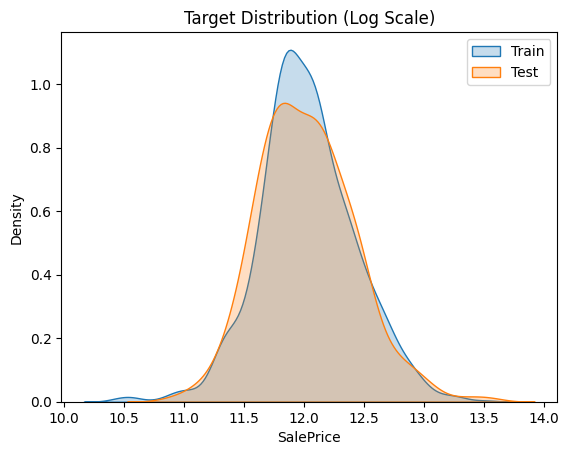

In [33]:
sns.kdeplot(y_train, label='Train', fill=True)
sns.kdeplot(y_test, label='Test', fill=True)
plt.legend()
plt.title('Target Distribution (Log Scale)')
plt.show()

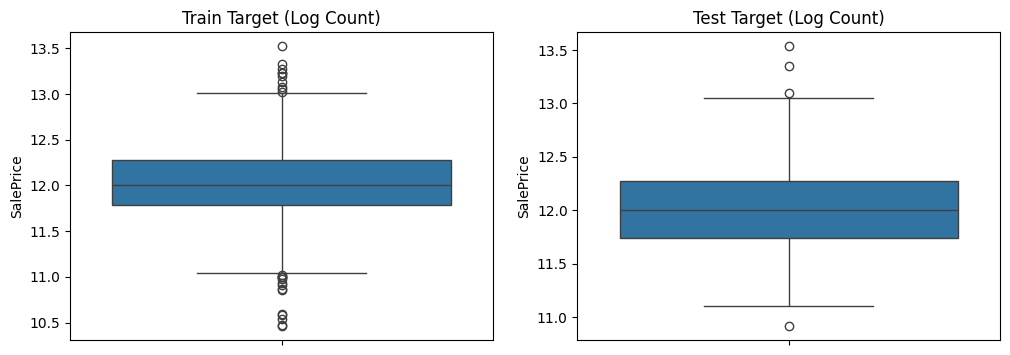

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y_train)
plt.title('Train Target (Log Count)')

plt.subplot(1, 2, 2)
sns.boxplot(y_test)
plt.title('Test Target (Log Count)')
plt.show()

<br>
<br>

## 3. 모델 학습 및 평가 준비




### 3.1 &nbsp;회귀 모델 성능 평가 함수

- 회귀 성능 지표 함수

In [35]:
from sklearn.metrics import mean_squared_error

# RMSLE 계산 함수
def rmsle_func(y, pred):
    """
    로그 변환을 통해 실제값과 예측값 간의 상대적인 오차를 측정한다.
    """
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    return np.sqrt(np.mean((log_y - log_pred) ** 2))  # 음수 방지


# RMSE 계산 함수
def rmse_func(y, pred):
    """
    예측값과 실제값 사이의 평균 제곱 오차의 제곱근을 구해 절대 오차의 평균적인 크기를 측정한다.
    """
    return np.sqrt(mean_squared_error(y, pred))

# 통합 평가 출력 함수
def evaluate_regr(y, pred):
    """
    RMSLE, RMSE, MSE 세 가지 회귀 평가 지표를 계산하고 출력한다.

    Parameters
    ----------
    y : array-like of shape (n_samples,)
        실제 타겟값 (로그 복원된 상태)
    pred : array-like of shape (n_samples,)
        예측값 (로그 복원된 상태)
    """
    rmsle_val = rmsle_func(y, pred)
    rmse_val = rmse_func(y, pred)
    mse_val = mean_squared_error(y, pred)
    print(f'RMSLE: {rmsle_val:.3f}, RMSE: {rmse_val:.3f}, MSE: {mse_val:.3f}')
    return rmsle_val, rmse_val, mse_val

<br>

- 예측 오차 분석 함수

In [36]:
def get_top_error_data(y_test, pred, n_tops = 5):
    """
    예측값과 실제값 간의 오차가 가장 큰 샘플 데이터를 상위 n개 출력한다.

    Parameters
    ----------
    y_test : array-like of shape (n_samples,)
        테스트 데이터 실제 타겟값
    pred : array-like of shape (n_samples,)
        모델 예측값
    n_tops : int, default=5

    Prints
    ------
    DataFrame
        실제 가격, 예측 가격, 그리고 이들의 차이를 포함한 결과 상위 n개 샘플
    """

    # 실제 타겟값(y_test)을 기반 DataFrame 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_sale_price'])
    result_df['predicted_sale_price']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_sale_price'] - result_df['predicted_sale_price'])

    print(result_df.sort_values('diff', ascending=False)[:n_tops])

<br>

- 평가 지표 출력 함수

In [37]:
# 모델 성능 비교 결과 저장 리스트
model_score = []

In [38]:
def evaluate_model_result(model, model_name, y_test, pred, feature_names, is_log_transform=True):
    """
    회귀 모델의 예측 결과를 평가하고, 주요 성능 지표와 오차가 큰 샘플을 출력한다.
    평가 결과를 전역 리스트(model_score)에 저장한다.

    Parameters
    ----------
    model : object
    model_name : str
    y_test : array-like of shape (n_samples,)
        테스트 데이터 실제 타겟값 (로그 변환된 상태일 수 있음)
    pred : array-like of shape (n_samples,)
        모델 예측값 (로그 변환된 상태일 수 있음)
    feature_names : list of str
        입력 피처 이름 리스트 (중요도 시각화 시 사용)
    is_log_transform : bool, default=True
        타겟값이 로그 변환되었는지 여부 (True일 경우 expm1으로 복원)

    Returns
    -------
    None
        주요 성능 지표를 출력하고, 결과를 전역 리스트 model_score에 저장한다.
    """

    # 로그 복원
    if is_log_transform:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)

    # 결과 출력
    print(f'### {model_name} ###')
    rmsle_val, rmse_val, mse_val = evaluate_regr(y_test, pred)

    get_top_error_data(pd.Series(y_test), pred)

    # # 선형 모델에 한해 중요도 시각화
    # # feature importance 출력 (coef_이 있는 모델에만)
    # if hasattr(model, 'coef_'):
    #     plot_feature_importance(model, feature_names)

    # 평가 결과 저장
    model_score.append({
        'Model': model_name,
        'RMSLE': round(rmsle_val, 3),
        'RMSE': round(rmse_val, 3),
        'MSE': round(mse_val, 3)
    })

<br>
<br>

### 3.2 &nbsp;회귀 모델 학습 및 평가 함수

- 스케일링 함수

In [39]:
from sklearn.preprocessing import StandardScaler

def scale_features(X_train, X_test):
    """
    학습용 X_train 기준으로 StandardScaler를 학습하고,
    X_train과 X_test를 스케일링하여 반환합니다.

    Returns
    -------
    X_train_scaled, X_test_scaled : ndarray
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


- 조기 종료 적용 함수

In [40]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from xgboost import XGBRegressor

def apply_early_stopping(model, model_name, X_train, y_train, X_test, y_test):
    """
    LightGBM/XGBoost 회귀 모델에 대해 조기 종료(Early Stopping)를 적용하여 학습을 수행한다.

    Parameters
    ----------
    model : object
    model_name : str
        모델 이름 (에러 메시지 출력용)
    X_train : array-like of shape (n_samples, n_features)
        학습용 입력 데이터
    y_train : array-like of shape (n_samples,)
        학습용 타겟 데이터
    X_test : array-like of shape (n_samples, n_features)
        검증용 입력 데이터
    y_test : array-like of shape (n_samples,)
        검증용 타겟 데이터

    Returns
    -------
    None
        모델 학습은 내부적으로 수행되며 반환값은 없다.
        조기 종료가 적용된 상태로 모델이 학습된다.

    Raises
    ------
    ValueError
        지원하지 않는 모델 타입일 경우 예외 발생
    """

    eval_set = [(X_train, y_train), (X_test, y_test)]

    if isinstance(model, LGBMRegressor):
        model.fit(
            X_train, y_train,
            eval_set=eval_set,
            eval_metric='rmse',
            callbacks=[
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0)
            ]
        )
    elif isinstance(model, XGBRegressor):
        model.fit(
            X_train, y_train,
            eval_set=eval_set,
            # eval_metric='rmse',
            # early_stopping_rounds=50,
            verbose=False
        )
    else:
        raise ValueError(f'Early stopping not supported for model type: {model_name}')

<br>

- 모델 학습 및 평가 함수

In [41]:
def train_and_predict_model(model, model_name, X_train, X_test, y_train, y_test, feature_names, is_log_transform=True):
    """
    회귀 모델을 학습하고 테스트 데이터를 예측한 뒤, 결과를 평가하는 통합 함수

    XGBoost 또는 LightGBM 모델의 경우 조기 종료(Early Stopping)를 적용하며,
    해당 모델들은 NumPy 배열 입력이 필요하므로 내부에서 변환이 이루어진다.

    예측 결과는 로그 변환된 상태로 반환되며, 평가 시 로그 역변환 여부는 is_log_transform 인자에 따라 처리된다.

    Parameters
    ----------
    model : object
    model_name : str
    X_train : array-like of shape (n_samples, n_features)
        학습용 입력 데이터
    X_test : array-like of shape (n_samples, n_features)
        테스트용 입력 데이터
    y_train : array-like of shape (n_samples,)
        학습용 타겟값
    y_test : array-like of shape (n_samples,)
        테스트용 타겟값
    feature_names : list of str
        피처 이름 리스트 (선형 모델 계수 시각화 등에 사용)
    is_log_transform : bool, default=True
        타겟값의 로그 변환 여부. True인 경우 평가 시 로그 역변환 수행

    Returns
    -------
    model : object
        학습이 완료된 회귀 모델 객체
    """

    # XGB, LGBM: NumPy 변환 필요
    # XGBoost / LightGBM은 NumPy 배열 사용
    if isinstance(model, (XGBRegressor, LGBMRegressor)):
        X_train, X_test = X_train.values, X_test.values
        y_train, y_test = y_train.values, y_test.values

    # 모델 학습
    if isinstance(model, (XGBRegressor, LGBMRegressor)):
        apply_early_stopping(model, model_name, X_train, y_train, X_test, y_test)
    else:
        model.fit(X_train, y_train)

    # 예측
    pred = model.predict(X_test)

    # 평가 시에는 로그 역변환만 수행
    evaluate_model_result(
        model=model,
        model_name=model_name,
        y_test=y_test,  # log 상태
        pred=pred,      # log 상태
        feature_names=feature_names,
        is_log_transform=is_log_transform
    )

    return model

<br>
<br>

### 3.3 &nbsp;개별 모델 실행 함수

- 개별 회귀 모델을 실행하고 학습 및 예측 결과를 평가하는 함수

In [42]:
"""
    각 함수는 회귀 모델을 정의한 후, train_and_predict_model()을 호출하여 다음 과정을 자동으로 수행한다.

        1. 모델 학습 (필요 시 조기 종료 적용)
        2. 테스트 데이터 예측
        3. 성능 평가 지표 출력 (RMSLE, RMSE, MSE)
        4. 오차가 큰 예측 샘플 출력
        5. 평가 결과를 전역 리스트 model_score에 저장

    Parameters
    ----------
    X_train, X_test : array-like of shape (n_samples, n_features)
        학습/테스트 입력 데이터
    y_train, y_test : array-like of shape (n_samples,)
        학습/테스트 타겟값 (log 변환 여부는 is_log_transform에 따름)
    feature_names : list of str
        피처 이름 목록 (선형 모델의 중요도 시각화 시 사용)
    alpha : float, optional
        릿지/라쏘 모델의 정규화 강도 (해당 모델 함수에서만 사용됨)
    n_estimators : int, optiona
        트리 기반 모델의 트리 개수 (RandomForest, XGBoost, LightGBM 전용)
    is_log_transform : bool, optional (default: True)
        타겟값의 로그 변환 여부. True인 경우 평가 시 로그 역변환 수행

    Returns
    -------
    model : object
        학습이 완료된 회귀 모델 객체
"""

def run_linear_regression(X_train, X_test, y_train, y_test, feature_names, is_log_transform=True):
    model = LinearRegression()
    return train_and_predict_model(model, 'LinearRegression',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

def run_ridge(X_train, X_test, y_train, y_test, feature_names, alpha=1.0, is_log_transform=True):
    model = Ridge(alpha=alpha)
    return train_and_predict_model(model, 'Ridge',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

def run_lasso(X_train, X_test, y_train, y_test, feature_names, alpha=1.0, is_log_transform=True):
    model = Lasso(alpha=alpha)
    return train_and_predict_model(model, 'Lasso',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

def run_random_forest(X_train, X_test, y_train, y_test, feature_names, n_estimators=500, is_log_transform=True):
    model = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, random_state=42)
    return train_and_predict_model(model, 'RandomForest',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

def run_xgboost(X_train, X_test, y_train, y_test, feature_names, n_estimators=500, is_log_transform=True):
    model = XGBRegressor(n_estimators=n_estimators,
                         eval_metric='rmse',
                         early_stopping_rounds=50,
                         n_jobs=-1,
                         random_state=42)
    return train_and_predict_model(model, 'XGBoost',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

def run_lightgbm(X_train, X_test, y_train, y_test, feature_names, n_estimators=500, is_log_transform=True):
    model = LGBMRegressor(n_estimators=n_estimators,
                          verbosity=-1,
                          n_jobs=-1,
                          random_state=42)
    return train_and_predict_model(model, 'LightGBM',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

<br>
<br>

### 3.4 &nbsp;회귀 계수 비교

피처별 회귀 계수를 시각화하여 모델별로 어떠한 피처의 회귀 계수로 구성되는지 확인한다.

- 모델 계수에서 중요 피처 추출 함수

In [43]:
def get_top_bottom_coef(model, feature_names, top_n=10):
    """
    선형 회귀 모델의 계수(coef_)를 바탕으로 가장 영향력 있는 피처들을 추출한다.
    top_n 개수만큼 가장 양(+)의 영향을 주는 피처와 가장 음(-)의 영향을 주는 피처를 반환한다.

    Returns
    -------
    coef_high : pd.Series
        계수가 가장 큰 상위 top_n 피처

    coef_low : pd.Series
        계수가 가장 작은 하위 top_n 피처
    """

    coef = pd.Series(model.coef_, index=feature_names)

    coef_high = coef.sort_values(ascending=False).head(top_n)
    coef_low = coef.sort_values(ascending=True).head(top_n)

    return coef_high, coef_low

<br>

- 모델별 회귀 계수 시각화 함수

In [44]:
def visualize_coefficient(models, feature_names):
    """
    주어진 회귀 모델 리스트의 계수를 시각화한다.
    각 모델별로 subplot에 상위/하위 영향력 피처를 barplot으로 표시한다.

    Parameters
    ----------
    models : list
        학습이 완료된 선형 회귀 모델 객체들의 리스트
    feature_names : list or Index
        모델 학습에 사용된 피처 이름 리스트 (각 모델의 coef_과 매핑됨)
    """

    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=len(models))
    fig.tight_layout()

    for i_num, model in enumerate(models):
        # 상위/하위 영향 피처 추출

        coef_high, coef_low = get_top_bottom_coef(model, feature_names)
        # 하나의 시리즈로 병합 후 정렬 (시각화 순서 통일)
        coef_concat = pd.concat([coef_high, coef_low]).sort_values(ascending=False)

        # 서브플롯 타이틀 및 레이블 조정
        axs[i_num].set_title(model.__class__.__name__ + ' Coefficients', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-120)

        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)

        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

<br>

- alpha 값 및 교차검증 RMSE 출력 함수: GirdSearch

In [45]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    """
    Ridge 또는 Lasso 모델에 대해 GridSearchCV를 수행하여
    최적의 alpha 값을 찾고, 교차 검증 기반 RMSE를 출력한다.

    Parameters
    ----------
    model : object
        Ridge 또는 Lasso 등 선형 회귀 모델 객체
    params : dict
        alpha 값 리스트를 포함하는 파라미터 딕셔너리
        e.g., {'alpha': [0.1, 1, 10]}

    Returns
    -------
    best_model : object
        GridSearchCV를 통해 선택된 최적의 모델 객체 (best_estimator_)
    """

    # GridSearchCV로 alpha 튜닝 수행 (neg_mean_squared_error 기준)
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target_log)

    # 평균 RMSE 계산
    rmse = np.sqrt(-1* grid_model.best_score_)

    # 결과 출력
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

<br>

- 선형 회귀 기반 모델 학습 및 계수 시각화
    - 각 모델의 피처 계수를 시각화하여 변수 중요도 비교한다.

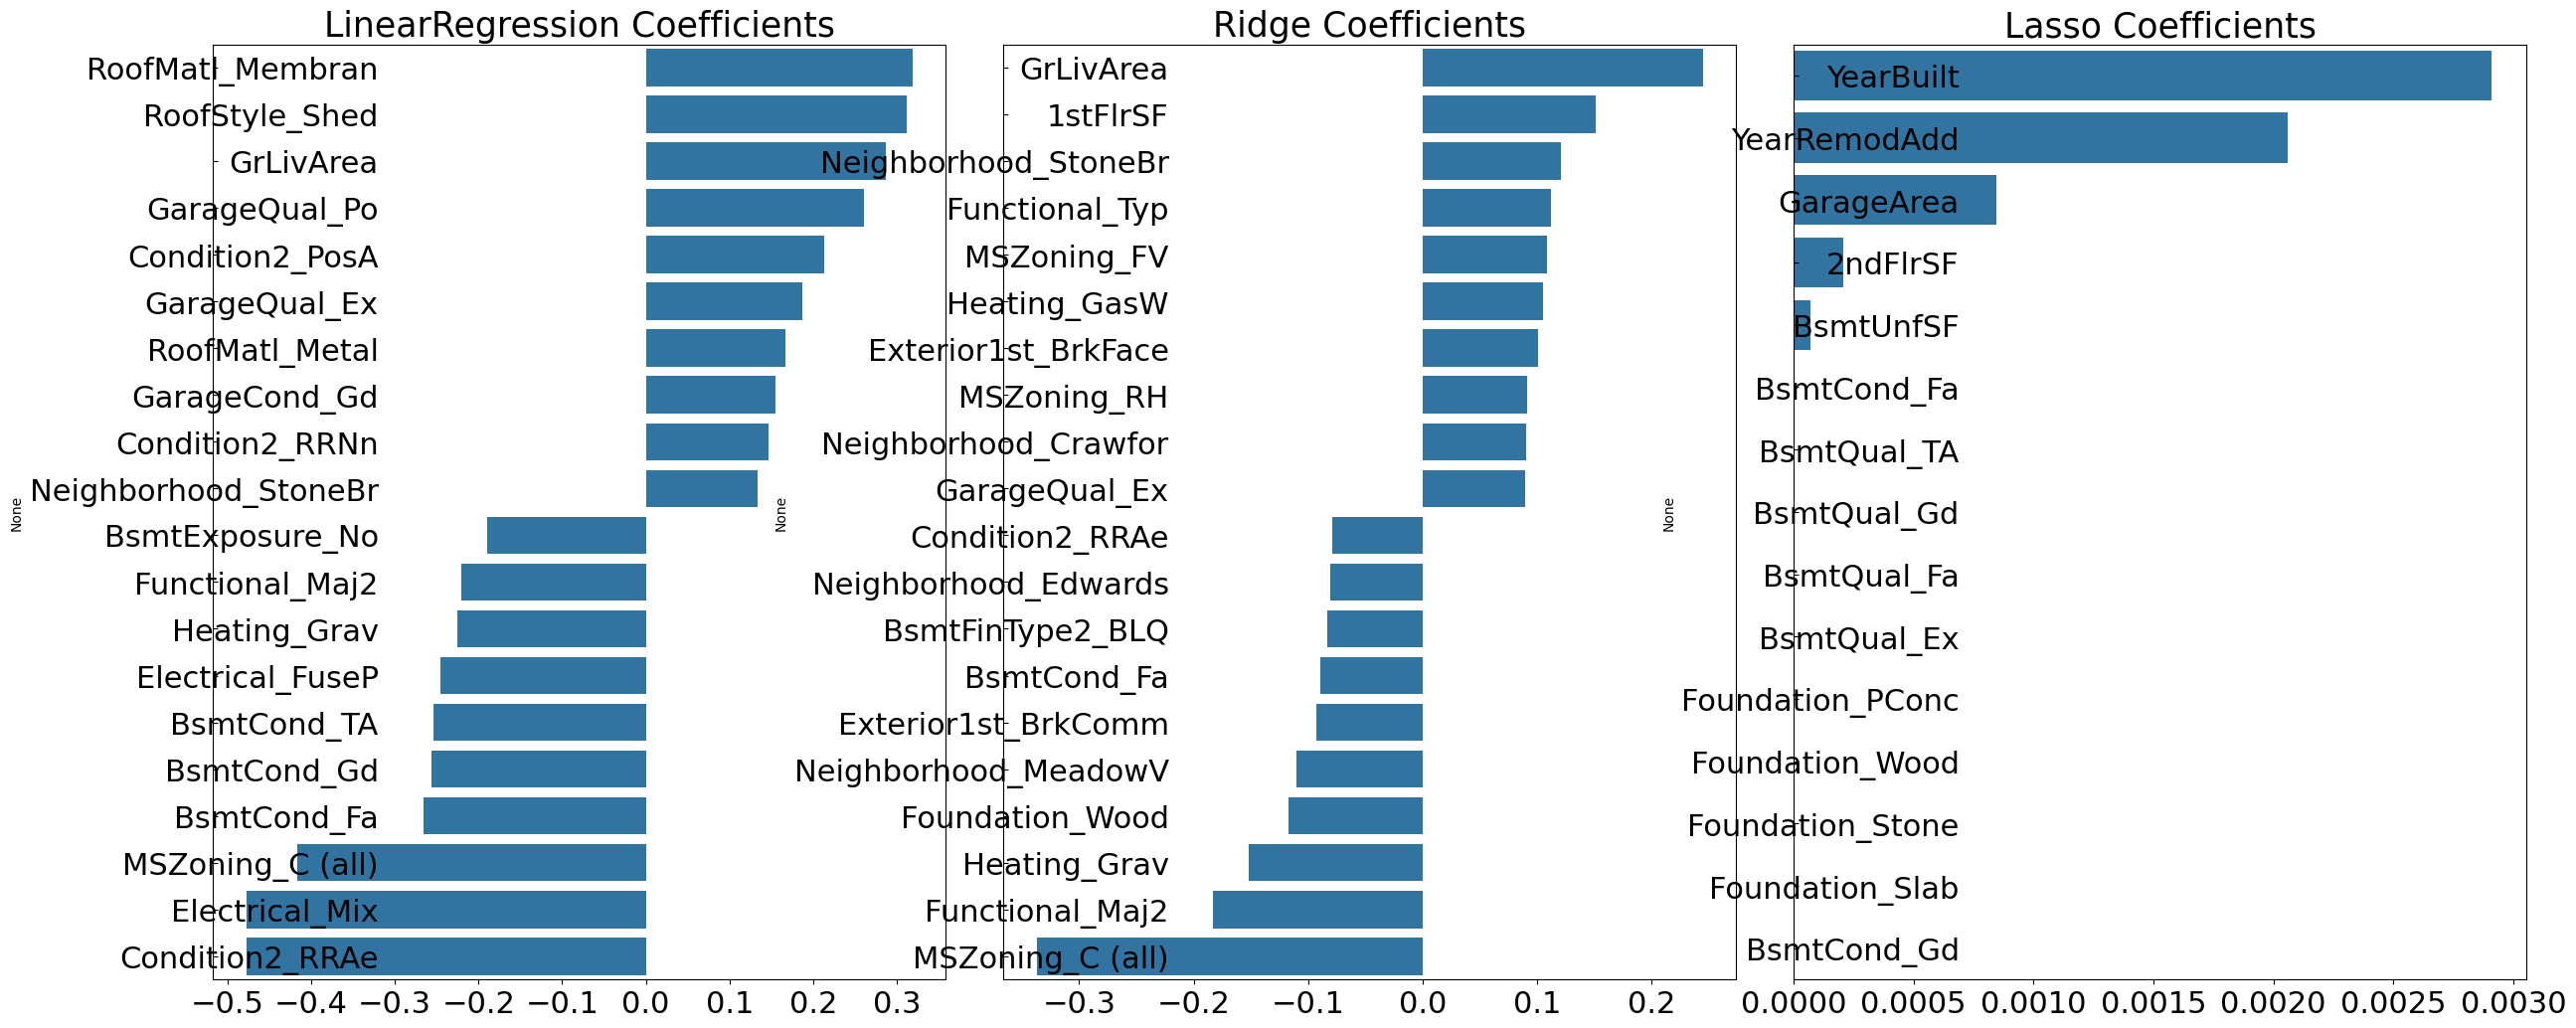

In [46]:
# default alpha
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

models = [lin_reg, ridge, lasso]

visualize_coefficient(models, feature_names=X_features.columns)

모델별 회귀 계수를 보면 OLS 기반의 LinearRegression과 Ridge의 경우는 회귀 계수가 유사한 형태로 분포되어 있다.


반면 Lasso 모델은 대부분의 회귀 계수 값이 0에 가깝고 YearBuilt, YearRemodAdd 등 소수의 변수만 크게 반영되어 있다. 규제 강도가 너무 강해 유용한 변수들까지 억제된 결과로 해석된다.

<br>

과도한 피처 제거를 방지하고 중요한 변수만 적절히 반영하도록 하기 위해  
Ridge와 Lasso 모델에 대해 alpha 하이퍼파라미터를 변화시키면서 최적 값을 도출해 본다.

In [47]:
# Ridge/Lasso 모델의 alpha 값 최적화를 위한 후보 파라미터 리스트 정의
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

# 최적 모델 객체
best_rige = print_best_params(ridge, ridge_params)
best_lasso = print_best_params(lasso, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


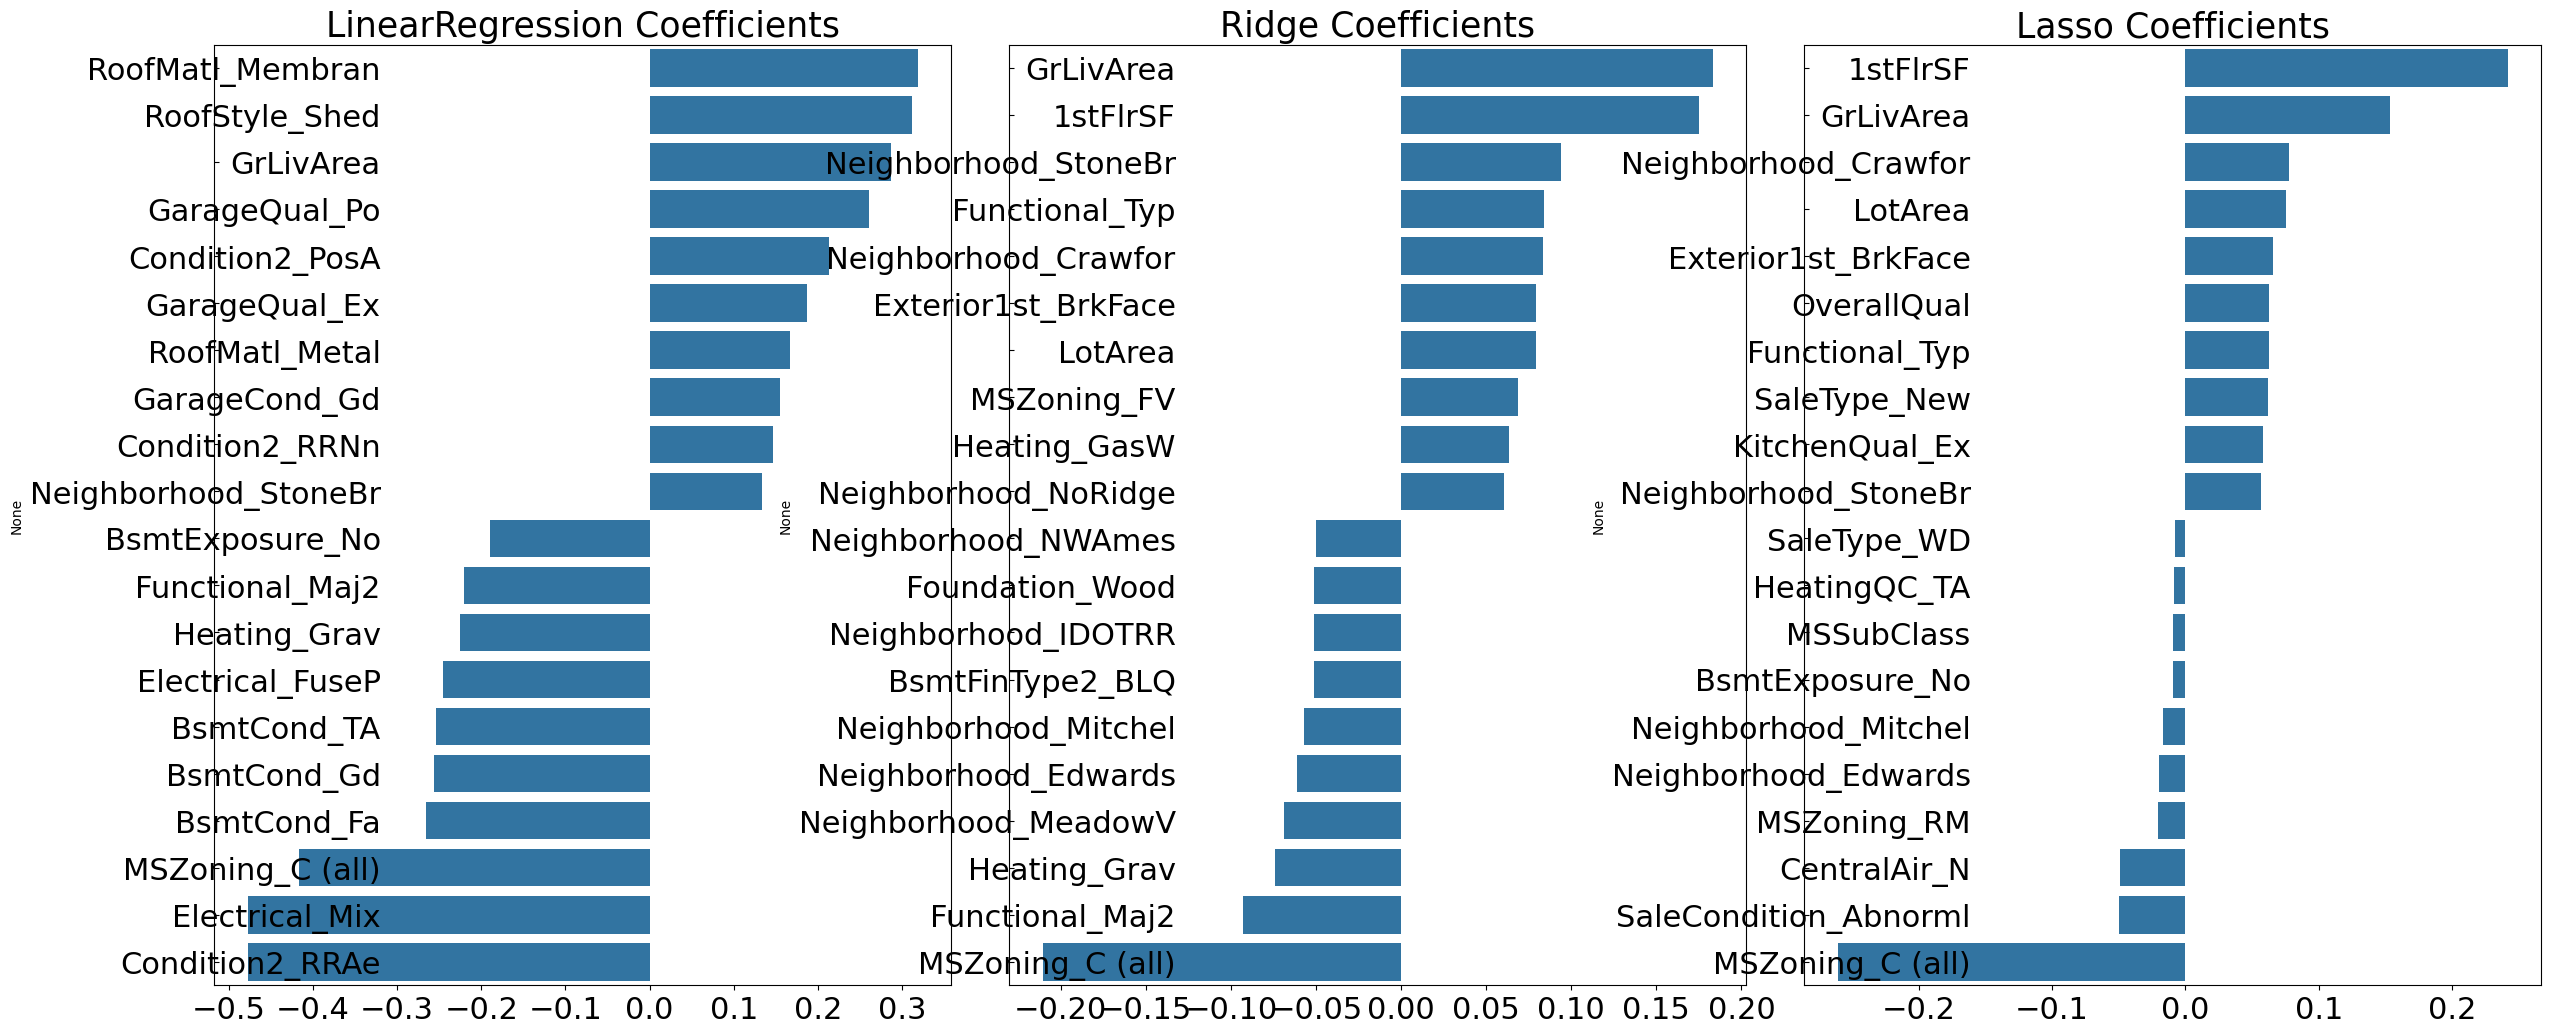

In [48]:
# 최적 alpha
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

ridge = Ridge(alpha=5)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

models = [lin_reg, ridge, lasso]

visualize_coefficient(models, feature_names=X_features.columns)

최적 알파를 적용한 결과 1stFlrSF, GrLivArea, KitchenQual_Ex 등 다양한 피처가 일정 수준 이상의 계수를 가지게 되었다.



<br>
<br>

## 4. 모델 비교 및 선택

동일한 학습/테스트 데이터와 설정을 유지하면서 회귀
모델별 성능을 비교한다.

In [49]:
# 모델 실행 함수에 공통적으로 전달할 기본 argument
default_args = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': X_features.columns,
    'is_log_transform': True
}

In [50]:
# 스케일링 적용 argument
scaled_args = default_args.copy()
scaled_args['X_train'], scaled_args['X_test'] = scale_features(
    default_args['X_train'], default_args['X_test']
)

### 4.1 &nbsp;LinearRegression

In [51]:
# LinearRegression
lin_reg = run_linear_regression(**scaled_args)

### LinearRegression ###
RMSLE: 0.128, RMSE: 21618.345, MSE: 467352847.378
     real_sale_price  predicted_sale_price      diff
15          395000.0              289330.0  105670.0
180         253293.0              347557.0   94264.0
58          225000.0              300196.0   75196.0
7           625000.0              550903.0   74097.0
208         260000.0              329988.0   69988.0


<br>

### 4.2 &nbsp;Ridge

In [52]:
# Ridge
ridge_reg = run_ridge(**scaled_args, alpha=10)

### Ridge ###
RMSLE: 0.126, RMSE: 21321.320, MSE: 454598684.274
     real_sale_price  predicted_sale_price      diff
15          395000.0              290416.0  104584.0
180         253293.0              351830.0   98537.0
7           625000.0              545751.0   79249.0
58          225000.0              299837.0   74837.0
208         260000.0              331591.0   71591.0


In [53]:
# Ridge
ridge_reg = run_ridge(**scaled_args, alpha=50)

### Ridge ###
RMSLE: 0.121, RMSE: 20997.939, MSE: 440913425.627
     real_sale_price  predicted_sale_price      diff
15          395000.0              289798.0  105202.0
180         253293.0              354554.0  101261.0
7           625000.0              534902.0   90098.0
208         260000.0              330867.0   70867.0
176         250000.0              317947.0   67947.0


<br>

### 4.3 &nbsp;Lasso

In [54]:
# Lasso
lasso_reg = run_lasso(**scaled_args, alpha=0.01)

### Lasso ###
RMSLE: 0.104, RMSE: 22024.987, MSE: 485100072.116
     real_sale_price  predicted_sale_price      diff
255         755000.0              586607.0  168393.0
7           625000.0              497907.0  127093.0
15          395000.0              275764.0  119236.0
180         253293.0              340616.0   87323.0
32          311500.0              243067.0   68433.0


In [55]:
# Lasso
lasso_reg = run_lasso(**scaled_args, alpha=0.1)

### Lasso ###
RMSLE: 0.207, RMSE: 48491.594, MSE: 2351434686.514
     real_sale_price  predicted_sale_price      diff
255         755000.0              367355.0  387645.0
7           625000.0              345541.0  279459.0
171         485000.0              302073.0  182927.0
211         402000.0              250139.0  151861.0
15          395000.0              244070.0  150930.0


<br>

### 4.4 &nbsp;RandomForest

In [56]:
# 랜덤 포레스트
rf_reg = run_random_forest(**default_args, n_estimators=500)

### RandomForest ###
RMSLE: 0.120, RMSE: 27645.767, MSE: 764288446.048
     real_sale_price  predicted_sale_price      diff
255         755000.0              505645.0  249355.0
7           625000.0              457172.0  167828.0
180         253293.0              355453.0  102160.0
32          311500.0              211506.0   99994.0
15          395000.0              308699.0   86301.0


In [57]:
# 랜덤 포레스트
rf_reg = run_random_forest(**default_args, n_estimators=300)

### RandomForest ###
RMSLE: 0.120, RMSE: 27711.645, MSE: 767935294.486
     real_sale_price  predicted_sale_price      diff
255         755000.0              503576.0  251424.0
7           625000.0              457936.0  167064.0
32          311500.0              210619.0  100881.0
180         253293.0              352543.0   99250.0
15          395000.0              309516.0   85484.0


<br>

### 4.5 &nbsp;XGBoost

In [58]:
# XGBoost
xgb_reg = run_xgboost(**default_args, n_estimators=500)

### XGBoost ###
RMSLE: 0.129, RMSE: 27766.769, MSE: 770993487.361
     real_sale_price  predicted_sale_price      diff
255         755000.0              508943.0  246057.0
7           625000.0              488828.0  136172.0
180         253293.0              378162.0  124869.0
15          395000.0              291271.0  103729.0
238         285000.0              377424.0   92424.0


In [59]:
# XGBoost
xgb_reg = run_xgboost(**default_args, n_estimators=300)

### XGBoost ###
RMSLE: 0.129, RMSE: 27766.769, MSE: 770993487.361
     real_sale_price  predicted_sale_price      diff
255         755000.0              508943.0  246057.0
7           625000.0              488828.0  136172.0
180         253293.0              378162.0  124869.0
15          395000.0              291271.0  103729.0
238         285000.0              377424.0   92424.0


<br>

### 4.6 &nbsp;LgihtGBM

In [60]:
# LightGBM
lgbm_reg = run_lightgbm(**default_args, n_estimators=500)

### LightGBM ###
RMSLE: 0.114, RMSE: 25604.356, MSE: 655583065.114
     real_sale_price  predicted_sale_price      diff
255         755000.0              522012.0  232988.0
7           625000.0              492541.0  132459.0
180         253293.0              381026.0  127733.0
15          395000.0              280253.0  114747.0
270         197000.0              279467.0   82467.0


In [61]:
# LightGBM
lgbm_reg = run_lightgbm(**default_args, n_estimators=300)

### LightGBM ###
RMSLE: 0.114, RMSE: 25604.356, MSE: 655583065.114
     real_sale_price  predicted_sale_price      diff
255         755000.0              522012.0  232988.0
7           625000.0              492541.0  132459.0
180         253293.0              381026.0  127733.0
15          395000.0              280253.0  114747.0
270         197000.0              279467.0   82467.0


<br>

### 4.7 &nbsp;Baseline 모델 성능 비교

In [62]:
model_score_df = pd.DataFrame(model_score)
model_score_df

,Model,RMSLE,RMSE,MSE
0,LinearRegression,0.128,21618.345,4.673528e+08
1,Ridge,0.126,21321.320,4.545987e+08
2,Ridge,0.121,20997.939,4.409134e+08
3,Lasso,0.104,22024.987,4.851001e+08
4,Lasso,0.207,48491.594,2.351435e+09
5,RandomForest,0.120,27645.767,7.642884e+08
6,RandomForest,0.120,27711.645,7.679353e+08
7,XGBoost,0.129,27766.769,7.709935e+08
8,XGBoost,0.129,27766.769,7.709935e+08
9,LightGBM,0.114,25604.356,6.555831e+08


In [63]:
model_score_df.sort_values(by=['RMSLE', 'RMSE', 'MSE'])

,Model,RMSLE,RMSE,MSE
3,Lasso,0.104,22024.987,4.851001e+08
9,LightGBM,0.114,25604.356,6.555831e+08
10,LightGBM,0.114,25604.356,6.555831e+08
5,RandomForest,0.120,27645.767,7.642884e+08
6,RandomForest,0.120,27711.645,7.679353e+08
2,Ridge,0.121,20997.939,4.409134e+08
1,Ridge,0.126,21321.320,4.545987e+08
0,LinearRegression,0.128,21618.345,4.673528e+08
7,XGBoost,0.129,27766.769,7.709935e+08
8,XGBoost,0.129,27766.769,7.709935e+08


- Lasso는 RMSLE 기준으로 가장 낮은 값을 기록하며 로그 스케일 기준 비율 오차에 강한 것을 알 수 있다.

- Ridge는 RMSE 기준으로 가장 낮은 값을 기록하며 실제 금액 예측 정확도에서 가장 우수한 성능을 보인다.

- 기본 LinearRegression도 선형 기반이지만 준수한 성능을 보인다.

- 트리 기반 모델 (LightGBM, XGBoost, RandomForest)은 비교적 높은 RMSE 수치를 보이며, 기본 설정에서는 선형 회귀 기반 모델보다 성능이 낮은 것으로 나타난다.

- XGBoost는 RMSE와 MSE에서 가장 낮은 순위를 기록하여 하이퍼파라미터 튜닝의 필요성을 알 수 있다.

<br>

Baseline 성능 비교 결과를 기반으로  
다음의 단계로 실험을 진행하여 최종 모델을 선정한다.

>(1) 트리 기반 모델 하이퍼파라미터 튜닝  
> ⸰ &nbsp;&nbsp;LightGBM과 XGBoost의 주요 하이퍼파라미터를 대상으로 GridSearchCV와 RandomizedSearchCV 적용   
>  ⸰ &nbsp;&nbsp;목표: 선형 회귀 기반 모델보다 우수한 성능 확보

>(2) 스태킹(Ensemble Stacking) 적용  
⸰ &nbsp;&nbsp;선형 모델(Ridge, Lasso, - LinearRegression)과 트리 기반 모델(LightGBM, XGBoost, RandomForest)을 Base Learner로 사용  
⸰ &nbsp;&nbsp;메타 모델은 기본적으로 Lasso 또는 XGBoost 등으로 설정하여 조합 실험 예정  
⸰ &nbsp;&nbsp;목표: 예측 결과를 개별 모델 대비 더 낮은 RMSE로 최종 향상시키는 것

>(3) 캐글 제출  
⸰ &nbsp;&nbsp;최종 예측값은 로그 변환 역변환 후 submission.csv 파일로 저장  
⸰ &nbsp;&nbsp;Kaggle 평가 기준은 RMSE이므로 튜닝과 스태킹 시 해당 기준 고려



In [64]:
# # 모델 성능 결과 초기화 - 필요 시 실행
# model_score.clear()
# model_score_df = pd.DataFrame(model_score)

<br>
<br>

## 5. 하이퍼파라미터 튜닝

- 조기 종료 파라미터 반환 함수

In [65]:
def get_fit_params_with_early_stopping(model, X_train, X_test, y_train, y_test):
    """
    LightGBM 또는 XGBoost 모델의 학습 시 조기 종료(Early Stopping)를 적용하기 위한
    fit() 파라미터 딕셔너리를 생성하여 반환한다.

    GridSearchCV 또는 RandomizedSearchCV의 fit() 호출 시 fit_params 인자로 사용된다.

    Parameters
    ----------
    model : 학습 대상 모델 객체
    X_train, X_test, y_train, y_test : 학습/검증 데이터

    Returns
    -------
    fit_params : dict
        모델 학습 시 fit()에 전달할 파라미터
    """

    eval_set = [(X_train, y_train), (X_test, y_test)]

    if isinstance(model, LGBMRegressor):
        return {
            'eval_set': eval_set,
            'eval_metric': 'rmse',
            'callbacks': [
                early_stopping(stopping_rounds=50, verbose=False),
                log_evaluation(period=0)
            ]
        }

    elif isinstance(model, XGBRegressor):
        return {
            'eval_set': eval_set,
            'verbose': False
        }

    else:
        return {}  # 일반 회귀 모델은 특별한 fit_params 필요 없음

<br>

- 튜닝된 최적 모델 평가 함수

In [66]:
from sklearn.metrics import mean_squared_error, mean_squared_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(np.maximum(pred, 0))  # 예측값 음수 방지
    return np.sqrt(np.mean((log_y - log_pred) ** 2))

def evaluate_best_model(grid_cv, X_test, y_test):
    """
    GridSearchCV/RandomizedSearchCV로 튜닝된 최적 회귀 모델을
    테스트 세트에 대해 평가하고, 주요 회귀 지표를 출력한다.

    Parameters
    ----------
    grid_cv : GridSearchCV 또는 RandomizedSearchCV 객체
        사전에 fit()이 완료된 객체로, 최적 모델(best_estimator_)을 포함하고 있어야 함
    X_test : array-like of shape (n_samples, n_features)
        테스트 피처 (원핫 인코딩 상태)
    y_test : array-like of shape (n_samples,)
        테스트 타겟 (log 변환 상태)

    Prints
    ------
    - 최적 하이퍼파라미터 (best_params_)
    - 교차 검증 기반 최고 성능 (neg-MSE 기준)
    - 로그 복원된 테스트 세트에 대한 RMSLE, RMSE, MSE
    """

    print('Best Hyperparameters:', grid_cv.best_params_)
    print('Best Cross-Validation Score (neg-MSE 기준):', grid_cv.best_score_)

    best_model = grid_cv.best_estimator_
    pred = best_model.predict(X_test)

    # 로그 복원
    y_test_exp = np.expm1(y_test)
    pred_exp = np.expm1(pred)

    print('\nTest Evaluation')
    print(f'RMSLE: {rmsle(y_test_exp, pred_exp):.4f}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test_exp, pred_exp)):.4f}')
    print(f'MSE  : {mean_squared_error(y_test_exp, pred_exp):.4f}')

    return best_model

<br>

### 5.1 &nbsp;GirdSearch: LightGBM

In [67]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# 튜닝 대상 파라미터
lgbm_params = {
    'n_estimators': [30, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    # 'num_leaves': [31, 64, 128],
}

# 모델 정의
lgbm_reg = LGBMRegressor(
    boost_from_average=False,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
    )

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(lgbm_reg, X_train, X_test, y_train, y_test)

# GridSearchCV 정의
grid_cv_lgbm = GridSearchCV(lgbm_reg, lgbm_params, cv=3, scoring='neg_mean_squared_error')

# 학습 시 추가 fit_params 전달
grid_cv_lgbm.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_lgbm_grid = evaluate_best_model(grid_cv_lgbm, X_test, y_test)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
Best Cross-Validation Score (neg-MSE 기준): -0.017625909493173667

Test Evaluation
RMSLE: 0.1123
RMSE : 24133.2193
MSE  : 582412273.3030


<br>

### 5.2 &nbsp;GirdSearch: XGBoost

In [68]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# 튜닝 대상 파라미터
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# 모델 정의
xgb_reg = XGBRegressor(
    eval_metric='rmse',
    early_stopping_rounds=10,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
    )

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(xgb_reg, X_train, X_test, y_train, y_test)

# GridSearchCV 정의
grid_cv_xgb = GridSearchCV(xgb_reg, xgb_params, cv=3, scoring='neg_mean_squared_error')

# 학습 시 추가 fit_params 전달
grid_cv_xgb.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_xgb_grid = evaluate_best_model(grid_cv_xgb, X_test, y_test)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Score (neg-MSE 기준): -0.01599569005416965

Test Evaluation
RMSLE: 0.1095
RMSE : 23534.7460
MSE  : 553884268.2788


<br>

### 5.3 &nbsp;RandomSearch: LightGBM

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

# 튜닝 대상 파라미터
lgbm_param_dist = {
    'n_estimators': [30, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    # 'num_leaves': [31, 64, 128],
}

# 모델 정의
lgbm_reg = LGBMRegressor(
    boost_from_average=False,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
    )

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(lgbm_reg, X_train, X_test, y_train, y_test)

# RandomizedSearchCV 정의
rand_cv_lgbm = RandomizedSearchCV(
    estimator=lgbm_reg,
    param_distributions=lgbm_param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 학습
rand_cv_lgbm.fit(X_train, y_train, **fit_params)

# 평가
best_lgbm_rand = evaluate_best_model(rand_cv_lgbm, X_test, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.1}
Best Cross-Validation Score (neg-MSE 기준): -0.017625909493173667

Test Evaluation
RMSLE: 0.1123
RMSE : 24133.2193
MSE  : 582412273.3030


<br>

### 5.4 &nbsp;RandomSearch: XGBoost

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# 튜닝 대상 파라미터
xgb_param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# 모델 정의
xgb_reg = XGBRegressor(
    eval_metric='rmse',
    early_stopping_rounds=10,
    random_state=42,
    n_jobs=-1
)

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(
    xgb_reg, X_train, X_test, y_train, y_test
)

# RandomizedSearchCV 정의
random_cv_xgb = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 학습 시 추가 fit_params 전달
random_cv_xgb.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_xgb_rand = evaluate_best_model(random_cv_xgb, X_test, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best Cross-Validation Score (neg-MSE 기준): -0.016519023292996166

Test Evaluation
RMSLE: 0.1086
RMSE : 23392.3286
MSE  : 547201038.0661


<br>
<br>

## 6. Fine-tuning

하이어파라미터 튜닝을 통해 도출한 최적 조합을 기반으로,  
파라미터 조합을 수동으로 fine-tuning 하여 모델 성능의 추가 향상을 기대한다.

In [71]:
def evaluate_custom_model(model, X_test, y_test):
    """
    수동 설정한 회귀 모델을 테스트 세트에 대해 평가한다.

    Parameters
    ----------
    model : 학습 완료된 회귀 모델 객체
    X_test : 테스트 피처 (원핫 인코딩 포함, ndarray 또는 DataFrame)
    y_test : 테스트 타겟 (log 변환된 상태)

    Returns
    -------
    model : 입력된 모델 그대로 반환
    """

    pred = model.predict(X_test)
    y_test_exp = np.expm1(y_test)
    pred_exp = np.expm1(pred)

    print('\nCustom Model Evaluation')
    print(f'RMSLE: {rmsle(y_test_exp, pred_exp):.4f}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test_exp, pred_exp)):.4f}')
    print(f'MSE  : {mean_squared_error(y_test_exp, pred_exp):.4f}')

    return model

<br>

### 6.1 &nbsp;LightGBM

In [72]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.01}
# {'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.1}
# 최적 파라미터를 기반으로 수동 조정한 LightGBM 모델
custom_lgbm = LGBMRegressor(
    # 기본 구조
    n_estimators=1000,
    learning_rate=0.01, # 0.01
    max_depth=4,        # 4
    num_leaves=64,

    # # 규제 및 분할 관련
    # min_child_samples=30,
    # min_child_weight=1.0,
    # reg_alpha=0,
    # reg_lambda=0,

    # # 샘플링 비율
    subsample=0.8,
    colsample_bytree=0.8,

    # 기타 설정
    boost_from_average=False,    # 로그 변환 시 False가 안정적
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

fit_params = get_fit_params_with_early_stopping(custom_lgbm, X_train, X_test, y_train, y_test)
custom_lgbm.fit(X_train, y_train, **fit_params)

best_lgbm_custom = evaluate_custom_model(custom_lgbm, X_test, y_test)


Custom Model Evaluation
RMSLE: 0.1096
RMSE : 23532.2702
MSE  : 553767741.5720


<br>

### 6.2 &nbsp;XGB

In [73]:
from xgboost import XGBRegressor

# 최적 파라미터를 기반으로 수동 조정한 XGBoost 모델
custom_xgb = XGBRegressor(
    # 핵심 튜닝 파라미터
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=3,
    gamma=0.1,

    # 과적합 방지용 샘플링
    subsample=0.8,
    colsample_bytree=0.8,

    # 정규화
    reg_alpha=0.1,
    reg_lambda=1.0,

    # 조기 종료 및 평가
    early_stopping_rounds=50,
    eval_metric='rmse',

    # 기타 설정
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

fit_params = get_fit_params_with_early_stopping(custom_xgb, X_train, X_test, y_train, y_test)
custom_xgb.fit(X_train, y_train, **fit_params)

best_xgb_custom = evaluate_custom_model(custom_xgb, X_test, y_test)


Custom Model Evaluation
RMSLE: 0.1109
RMSE : 24604.7463
MSE  : 605393541.9334


<br>

## 7. &nbsp;Stacking

- 스태킹 데이터셋 생성 함수

In [74]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def get_stacking_base_datasets_by_train_func(
    model, model_name, X_train, y_train, X_test,
    feature_names, is_log_transform=True, n_folds=5
):
    """
    개별 모델을 KFold 방식으로 학습 및 예측하여,
    메타 모델 학습을 위한 스태킹 데이터셋(train/test)을 생성하는 함수입니다.

    이 함수는 train_and_predict_model()을 내부에서 호출하며,
    Fold별로 학습한 모델을 기반으로 검증 세트와 테스트 세트에 대한 예측값을 생성합니다.
    반환된 예측값은 메타 모델의 입력 feature로 사용됩니다.

    Parameters
    ----------
    model : estimator object
        학습에 사용할 회귀 모델 객체
    model_name : str
        모델의 이름 (로그 및 디버깅 용도)
    X_train : pd.DataFrame
        학습용 feature 데이터 (로그 변환 여부와 관계 없음)
    y_train : pd.Series
        학습용 타겟 데이터 (로그 변환된 상태일 수 있음)
    X_test : pd.DataFrame
        테스트용 feature 데이터 (평가용 test split)
    feature_names : list or pd.Index
    is_log_transform : bool, default=True
    n_folds : int, default=5

    Returns
    -------
    train_fold_pred : np.ndarray of shape (n_train, 1)
        각 fold의 validation set에 대한 예측값을 모은 배열. 메타 모델 학습에 사용됨
    test_pred_mean : np.ndarray of shape (n_test, 1)
        각 fold에서 테스트 세트에 대해 예측한 값의 평균. 메타 모델 테스트에 사용됨
    """

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    train_fold_pred = np.zeros((X_train.shape[0], 1))
    test_fold_pred = np.zeros((X_test.shape[0], n_folds))

    print(f'\n[{model_name}] 스태킹용 KFold 시작')

    for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
        print(f'\t[Fold {fold_idx + 1}/{n_folds}]')

        X_tr = X_train.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]
        X_val = X_train.iloc[valid_idx]
        y_val = y_train.iloc[valid_idx]

        model_fold = clone(model)
        trained_model = train_and_predict_model(
            model=model_fold,
            model_name=f'{model_name}_F{fold_idx+1}',
            X_train=X_tr,
            X_test=X_val,
            y_train=y_tr,
            y_test=y_val,
            feature_names=feature_names,
            is_log_transform=is_log_transform
        )

        val_pred = trained_model.predict(X_val)
        train_fold_pred[valid_idx, :] = val_pred.reshape(-1, 1)

        test_fold_pred[:, fold_idx] = trained_model.predict(X_test)

    test_pred_mean = np.mean(test_fold_pred, axis=1).reshape(-1, 1)

    return train_fold_pred, test_pred_mean

<br>

- 스태킹을 위한 개별 회귀 모델 구성
- 각 모델은 하이퍼파라미터 수동 조절할 수 있도록 정의

In [75]:


# 모델 정의
lin_reg = LinearRegression()
ridge_reg = Ridge(alpha=20)         # 고정
lasso_reg = Lasso(alpha=0.001)      # 고정


# {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
xgb_reg = XGBRegressor(
    n_estimators=1000,  # 1000
    learning_rate=0.01,  # 0.01
    max_depth=4,  # 4
    subsample=0.8,  # 0.8
    colsample_bytree=0.8,  # 0.8
    random_state=42
)

lgbm_reg = LGBMRegressor(
    n_estimators=1000,  # 1000
    learning_rate=0.05,  # 0.05
    max_depth=3,
    num_leaves=50,  # 50
    subsample=0.9,  # 0.9
    colsample_bytree=0.9,
    random_state=42
)

rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42)

<br>

- 스태킹 기반 학습/예측용 데이터 생성

In [76]:
"""
    각 개별 모델을 기반으로 KFold 방식의 교차검증을 수행하여 스태킹 학습에 사용할 예측 결과를 생성한다.

    - train_stack: 각 모델의 KFold 검증 세트 예측값 → 메타 모델 학습용
    - test_stack : 테스트 세트 예측값 (Fold 평균) → 메타 모델 예측용

    생성된 예측값은 모델명(key) 기준으로 딕셔너리에 저장된다.
"""

# 스태킹에 사용할 모델
models_to_stack = [
    ('Linear', lin_reg),
    ('Ridge', ridge_reg),
    ('Lasso', lasso_reg),
    ('XGBoost', xgb_reg),
    ('LightGBM', lgbm_reg),
    ('RandomForest', rf_reg),
]

# 결과 저장
stack_train_preds = {}
stack_test_preds = {}

# 각 모델에 대해 스태킹용 학습/예측 데이터 생성
for name, model in models_to_stack:
    train_stack, test_stack = get_stacking_base_datasets_by_train_func(
        model=model,
        model_name=name,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        feature_names=X_features.columns,
        is_log_transform=True,
        n_folds=5
    )
    stack_train_preds[name] = train_stack
    stack_test_preds[name] = test_stack

lin_train, lin_test = stack_train_preds['Linear'], stack_test_preds['Linear']
ridge_train, ridge_test = stack_train_preds['Ridge'], stack_test_preds['Ridge']
lasso_train, lasso_test = stack_train_preds['Lasso'], stack_test_preds['Lasso']
xgb_train, xgb_test = stack_train_preds['XGBoost'], stack_test_preds['XGBoost']
lgbm_train, lgbm_test = stack_train_preds['LightGBM'], stack_test_preds['LightGBM']
rf_train, rf_test = stack_train_preds['RandomForest'], stack_test_preds['RandomForest']


[Linear] 스태킹용 KFold 시작
	[Fold 1/5]
### Linear_F1 ###
RMSLE: 0.148, RMSE: 26306.994, MSE: 692057926.437
     real_sale_price  predicted_sale_price      diff
77          190000.0              352337.0  162337.0
114         745000.0              603912.0  141088.0
207         147000.0              287777.0  140777.0
136          82500.0              181544.0   99044.0
194         136000.0              221894.0   85894.0
	[Fold 2/5]
### Linear_F2 ###
RMSLE: 0.124, RMSE: 21963.159, MSE: 482380345.432
     real_sale_price  predicted_sale_price     diff
3           475000.0              378107.0  96893.0
198         556581.0              470913.0  85668.0
1           241500.0              159197.0  82303.0
194         316600.0              253787.0  62813.0
139         160000.0               98285.0  61715.0
	[Fold 3/5]
### Linear_F3 ###
RMSLE: 0.109, RMSE: 21266.875, MSE: 452279962.784
     real_sale_price  predicted_sale_price      diff
180         611657.0              465131.0  146526.0


<br>

- 메타 모델 학습을 위한 최종 스태킹 데이터 결합 및 학습

In [77]:
"""
    앞서 생성한 개별 모델의 예측값(lin, ridge, lasso, xgb, lgbm, rf)을 수평 결합하여
    메타 모델의 학습 및 테스트 입력으로 사용할 최종 피처 행렬을 구성한다.

    - Stack_final_X_train: KFold 기반 개별 모델들의 train 예측값 → 메타 모델 학습용
    - Stack_final_X_test : KFold 기반 개별 모델들의 test 예측값 → 메타 모델 예측용

    메타 모델로는 Lasso 회귀를 사용하며, 규제 강도는 alpha=0.001로 설정되어 있다.
"""

# 스태킹 결합 시 함께 포함
Stack_final_X_train = np.concatenate(
    (lin_train, ridge_train, lasso_train, xgb_train, lgbm_train, rf_train), axis=1
)
Stack_final_X_test = np.concatenate(
    (lin_test, ridge_test, lasso_test, xgb_test, lgbm_test, rf_test), axis=1
)

# 메타 모델 Lasso 사용
meta_model = Lasso(alpha=0.001)
# meta_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42)


meta_model.fit(Stack_final_X_train, y_train)
final_pred = meta_model.predict(Stack_final_X_test)

<br>

- 스태킹 모델 성능 평가: 로그 변환 여부에 따른 전후 성능 모두 비교
    - 로그 상태 성능은 모델 튜닝 및 내부 비교에 유용
    - 역변환은 실제 캐글 제출 시의 평가 기준(RMSE)과 직접적으로 대응

In [78]:
# 평가

from sklearn.metrics import mean_squared_error, mean_absolute_error  # 제출 전 MAE 비교

# 로그 복원
final_exp = np.expm1(final_pred)
y_test_exp = np.expm1(y_test)

# 평가 함수 정의
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(np.maximum(0, y_pred))) ** 2))

# 로그 상태
rmse_log = np.sqrt(mean_squared_error(y_test, final_pred))
mae_log = mean_absolute_error(y_test, final_pred)

# 로그 복원 상태
rmse = np.sqrt(mean_squared_error(y_test_exp, final_exp))
mae = mean_absolute_error(y_test_exp, final_exp)
rmsle_val = rmsle(y_test_exp, final_exp)

# 출력
print('스태킹 회귀 모델 평가 결과\n')
print(f'RMSE (log): {rmse_log:.4f}')
print(f'MAE  (log): {mae_log:.4f}\n')
print(f'RMSLE     : {rmsle_val:.4f}')
print(f'RMSE      : {rmse:.4f}')
print(f'MAE       : {mae:.4f}')

스태킹 회귀 모델 평가 결과

RMSE (log): 0.0990
MAE  (log): 0.0699

RMSLE     : 0.0990
RMSE      : 18542.1315
MAE       : 12170.0478


이번 회귀 문제의 최종 평가 지표는 RMSE이며,
다양한 전처리 및 모델링 실험을 수행한 결과 해당 모델 조합과 전처리 설정에서 가장 안정적이고 낮은 RMSE 성능을 확인하였다.

<br>

스태킹 모델 구성

- Base 모델: LinearRegression, Ridge, Lasso, XGBoost, LightGBM, RandomForest

- 메타 모델: Lasso(alpha=0.001)

<br>

이번 실험에서 다른 하이퍼파라미터나 모델 조합, 전처리 방식을 적용했을 때보다 제출용 평가 지표인 RMSE가 가장 낮게 측정되었기 때문에 이 구성이 최종 제출 모델로 적합하다고 판단한다.



<br>
<br>

## 8. &nbsp;Submission

In [79]:
test = pd.read_csv('/content/drive/MyDrive/DS/ML/test_house1.csv')

In [80]:
print(test.shape)

(1459, 80)


In [81]:
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
test.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

# 수치형 컬럼 결측값 평균 대체
num_cols = test.select_dtypes(include=['number']).columns
test[num_cols] = test[num_cols].fillna(test[num_cols].mean())
test_ohe1 = pd.get_dummies(test)
test_ohe2 = test_ohe1.reindex(columns=X_train.columns, fill_value=0)

# 편향 전처리 진행
test_ohe2[skew_features_top.index] = np.log1p(test_ohe2[skew_features_top.index])
test_ohe2 = pd.get_dummies(test_ohe2)

test_ohe2.shape

(1459, 269)

In [82]:
X_train.columns.equals(test_ohe2.columns)

True

In [83]:
submission = pd.read_csv('/content/drive/MyDrive/DS/ML/sample_submission_house1.csv')

In [84]:
submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [85]:
# 전체 학습 데이터 사용 (split 제거)
X_full = X_features
y_full = y_target_log  # 로그 변환된 타겟

# 결과 저장
stack_train_preds = {}
stack_test_preds = {}

for name, model in models_to_stack:
    train_stack, test_stack = get_stacking_base_datasets_by_train_func(
        model=model,
        model_name=name,
        X_train=X_full,           # 전체 데이터
        y_train=y_full,
        X_test=test_ohe2,         # 실제 제출용 test 데이터 전처리 결과
        feature_names=X_full.columns,
        is_log_transform=True,
        n_folds=5
    )
    stack_train_preds[name] = train_stack
    stack_test_preds[name] = test_stack

# 합치기
Stack_final_X_train = np.concatenate(
    [stack_train_preds[name] for name, _ in models_to_stack], axis=1
)
Stack_final_X_test_submission = np.concatenate(
    [stack_test_preds[name] for name, _ in models_to_stack], axis=1
)



[Linear] 스태킹용 KFold 시작
	[Fold 1/5]
### Linear_F1 ###
RMSLE: 0.130, RMSE: 20309.281, MSE: 412466895.680
     real_sale_price  predicted_sale_price      diff
229         235128.0              126714.0  108414.0
159         106000.0              183667.0   77667.0
21          115000.0               50735.0   64265.0
148         265979.0              202353.0   63626.0
36          311500.0              254679.0   56821.0
	[Fold 2/5]
### Linear_F2 ###
RMSLE: 0.140, RMSE: 26330.195, MSE: 693279171.989
     real_sale_price  predicted_sale_price      diff
83          212000.0              388598.0  176598.0
45          207500.0              357870.0  150370.0
237         745000.0              614127.0  130873.0
155         582933.0              465374.0  117559.0
240         144000.0              251852.0  107852.0
	[Fold 3/5]
### Linear_F3 ###
RMSLE: 0.124, RMSE: 19526.898, MSE: 381299749.303
     real_sale_price  predicted_sale_price      diff
268         147000.0              282314.0  135

In [86]:
# 1. base 모델 재학습 (훈련된 clone이 없어졌으므로 다시 fit 필요)
lin_reg.fit(X_features, y_target_log)
ridge_reg.fit(X_features, y_target_log)
lasso_reg.fit(X_features, y_target_log)
xgb_reg.fit(X_features, y_target_log)
lgbm_reg.fit(X_features, y_target_log)
rf_reg.fit(X_features, y_target_log)

RandomForestRegressor(max_depth=8, n_estimators=300, random_state=42)

In [87]:
# 2. 예측값 생성
lin_test_sub   = lin_reg.predict(test_ohe2).reshape(-1, 1)
ridge_test_sub = ridge_reg.predict(test_ohe2).reshape(-1, 1)
lasso_test_sub = lasso_reg.predict(test_ohe2).reshape(-1, 1)
xgb_test_sub   = xgb_reg.predict(test_ohe2).reshape(-1, 1)
lgbm_test_sub  = lgbm_reg.predict(test_ohe2).reshape(-1, 1)
rf_test_sub    = rf_reg.predict(test_ohe2).reshape(-1, 1)

In [88]:
# 3. 예측값 합쳐서 최종 입력 생성
Stack_final_X_test_submission = np.concatenate(
    (lin_test_sub, ridge_test_sub, lasso_test_sub, xgb_test_sub, lgbm_test_sub, rf_test_sub),
    axis=1
)

In [89]:
# 4. 메타 모델 예측 및 로그 복원
final_submission_log = meta_model.predict(Stack_final_X_test_submission)
final_submission_exp = np.expm1(final_submission_log)

In [90]:
submission['SalePrice'] = final_submission_exp

In [91]:
submission.to_csv('./submission.csv', index=False)

In [92]:
final_submission_exp.shape

(1459,)

In [93]:
final_submission_exp

array([123411.07272423, 152627.54775543, 184055.99060262, ...,
       163877.10228208, 119747.68884841, 229185.12509133])

In [94]:
submission

,Id,SalePrice
0,1461,123411.072724
1,1462,152627.547755
2,1463,184055.990603
3,1464,196905.777428
4,1465,195174.374678
...,...,...
1454,2915,84092.477112
1455,2916,81489.079177
1456,2917,163877.102282
1457,2918,119747.688848
